In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, root_mean_squared_error
from sklearn.cluster import k_means
import scipy.stats as stats
import xgboost as xgb

student_perf = pd.read_csv('/Users/rudeciabernard/Downloads/StudentPerformanceFactors.csv').dropna()


X = student_perf.drop(['Exam_Score'], axis= 1).copy()
X['Extracurricular_Activities'] = X['Extracurricular_Activities'].replace(['No', 'Yes'], [0, 1])
X['Motivation_Level'] = X['Motivation_Level'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
X['Access_to_Resources'] = X['Access_to_Resources'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
X['Internet_Access'] = X['Internet_Access'].replace(['No', 'Yes'], [0, 1])
X['Teacher_Quality'] = X['Teacher_Quality'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
X['School_Type'] = X['School_Type'].replace(['Public', 'Private'], [0, 1])
X['Peer_Influence'] = X['Peer_Influence'].replace(['Negative','Neutral', 'Positive'], [0, 1, 2])
X['Learning_Disabilities'] = X['Learning_Disabilities'].replace(['No', 'Yes'], [0, 1])
X['Parental_Education_Level'] = X['Parental_Education_Level'].replace(['High School', 'College', 'Postgraduate'], [0, 1, 2])
X['Gender'] = X['Gender'].replace(['Male', 'Female'], [0, 1])
X['Distance_from_Home'] = X['Distance_from_Home'].replace(['Near', 'Moderate', 'Far'], [0, 1, 2])
X['Parental_Involvement'] = X['Parental_Involvement'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
X['Family_Income'] = X['Family_Income'].replace(['Low', 'Medium', 'High'], [0, 1, 2])

y = student_perf[['Exam_Score']].copy()

nsp = pd.concat([X, y], axis= 1)
#nsp = 'numerical student performance'


/var/folders/v3/6qtbvpn1355529vflp4kdnxm0000gn/T/ipykernel_956/4040938965.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Extracurricular_Activities'] = X['Extracurricular_Activities'].replace(['No', 'Yes'], [0, 1])
/var/folders/v3/6qtbvpn1355529vflp4kdnxm0000gn/T/ipykernel_956/4040938965.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['Motivation_Level'] = X['Motivation_Level'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
/var/folders/v3/6qtbvpn1355529vflp4kdnxm0000gn/T/ipykernel_956/4040938965.py:20: FutureWarnin

Exploratory Analyses

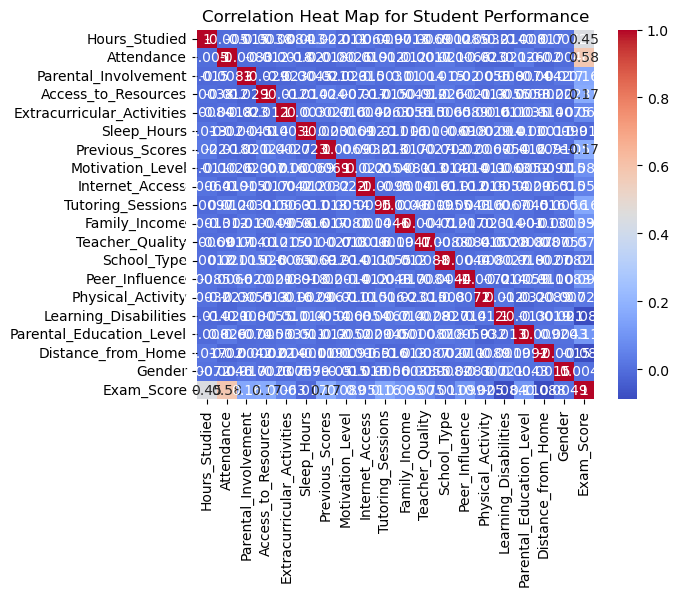

In [55]:
#Correlation Matrix and Heat Map:
nsp_corr_matrix = nsp.corr()
sns.heatmap(nsp_corr_matrix, cmap = 'coolwarm', annot= True)
plt.title('Correlation Heat Map for Student Performance')
plt.show()







'Attendance' and 'Hours Spent Studying' are clearly the most strongly correlated with test performance, with 'Access to Resources' and 'Previous Scores' tying for a distant third place. Let's take a closer look:

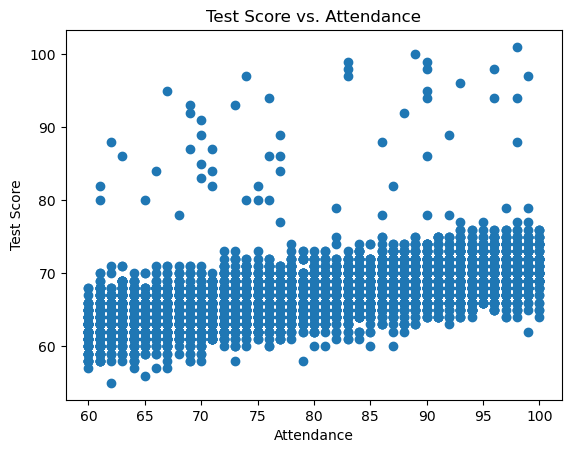

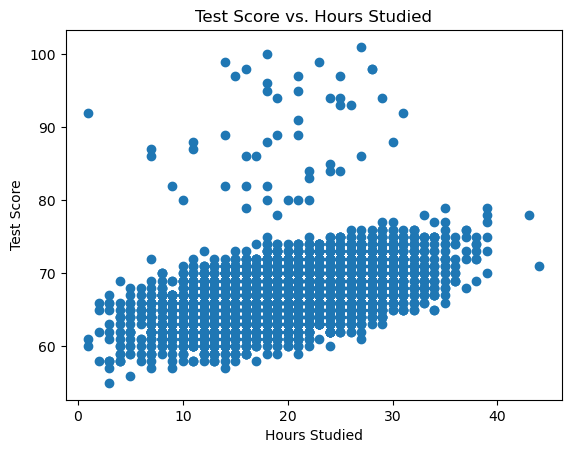

In [56]:
#Att
plt.scatter(X['Attendance'], y)
plt.title('Test Score vs. Attendance')
plt.xlabel('Attendance')
plt.ylabel('Test Score')
plt.show()

#Hours spent studying seems to be the most strongly correlated with performance.
plt.scatter(X['Hours_Studied'], y)
plt.title('Test Score vs. Hours Studied')
plt.xlabel('Hours Studied')
plt.ylabel('Test Score')
plt.show()

There appears to be two groups of people:

1: those whose time spent studying and attendance have an essentially linear relationship w/ their score (tend to be below 80)
    reminiscent of people who work really hard but lack natural aptitude; they are the vast majority of the dataset

2:  those whose time spent studying and attendance are only loosely related to their test score, if at all (tend to be above 80)
    perhaps these are the people who are naturally gifted; they make up a really small portion of the dataset


Let's look at them more closely:

Hours Spent Studying

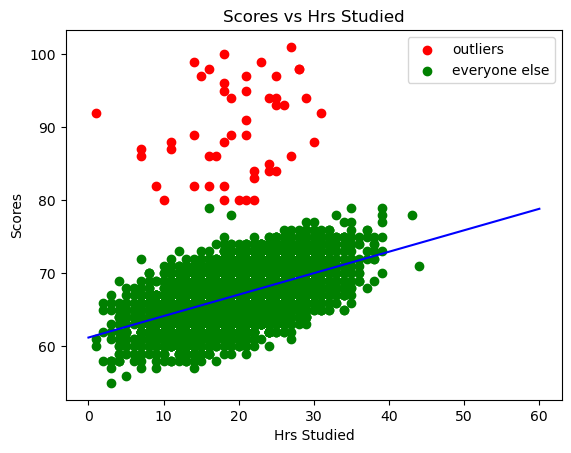

In [57]:

above_80 = student_perf[student_perf['Exam_Score'] >= 80]
below_80 = student_perf[student_perf['Exam_Score'] < 80]

#Best-fit Line for Non-Outliers
m, b = np.polyfit(below_80['Hours_Studied'], below_80['Exam_Score'], 1)
lowx = np.linspace(0, 60)
lowy = [m * x + b for x in lowx]




plt.scatter(above_80['Hours_Studied'], above_80['Exam_Score'], c= 'r', label = 'outliers')
plt.scatter(below_80['Hours_Studied'], below_80['Exam_Score'], c = 'g', label = 'everyone else')
plt.plot(lowx, lowy, c = 'b')
plt.legend()
plt.title('Scores vs Hrs Studied')
plt.xlabel('Hrs Studied')
plt.ylabel('Scores')
plt.show()


Attendance:

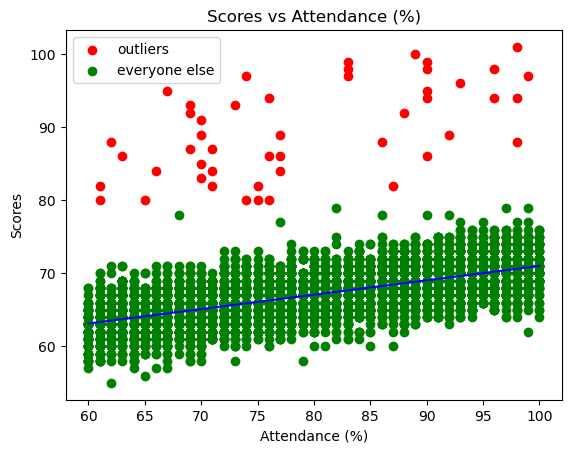

In [58]:

#Best-fit Line for Non-Outliers
m, b = np.polyfit(below_80['Attendance'], below_80['Exam_Score'], 1)
lowx = np.linspace(60, 100)
lowy = [m * x + b for x in lowx]



plt.scatter(above_80['Attendance'], above_80['Exam_Score'], c= 'r', label = 'outliers')
plt.scatter(below_80['Attendance'], below_80['Exam_Score'], c = 'g', label = 'everyone else')
plt.plot(lowx, lowy, c = 'b')
plt.legend()
plt.title('Scores vs Attendance (%)')
plt.xlabel('Attendance (%)')
plt.ylabel('Scores')
plt.show()

Does the data capture anything "special" about the outliers?

In [59]:
t_stats, p_vals  = stats.ttest_ind(nsp[nsp['Exam_Score'] < 80], nsp[nsp['Exam_Score'] >= 80])

results = pd.DataFrame()

results['t_statistic'] = t_stats
results['p_value'] = p_vals
results.index = student_perf.columns

results.sort_values(by = 'p_value')

,t_statistic,p_value
Exam_Score,-45.941533,0.000000
Physical_Activity,2.069112,0.038576
Learning_Disabilities,-1.406537,0.159614
Extracurricular_Activities,-1.284519,0.199007
School_Type,1.142553,0.253267
Motivation_Level,-1.128196,0.259280
Family_Income,-0.813516,0.415953
Sleep_Hours,0.757762,0.448621
Internet_Access,0.737793,0.460668
Peer_Influence,-0.727053,0.467220


Not really-- the only statistically significant difference is in weekly physical activity levels between the two groups. When we examine this more closely, the difference is not so staggering (totals about 20 minutes). Whatever special quality they have is probably something outside of the scope of the dataset.


In [60]:
print(f'Avg weekly physical  activity levels for outliers is {round(above_80.Physical_Activity.mean(), 4)} hours')
print(f'Median weekly physical  activity levels for outliers is {round(above_80.Physical_Activity.median(), 4)} hours')



print(f'Avg weekly activity levels for everyone else is {round(below_80.Physical_Activity.mean(), 4)} hours')
print(f'Median weekly activity levels for everyone else is {round(below_80.Physical_Activity.median(), 4)} hours')


Avg weekly physical  activity levels for outliers is 2.6667 hours
Median weekly physical  activity levels for outliers is 3.0 hours
Avg weekly activity levels for everyone else is 2.975 hours
Median weekly activity levels for everyone else is 3.0 hours


I am also curious if there are relationships between the four variables most strongly correlated with test performance. Investigating further, the relationships appear weak at best:

<Axes: >

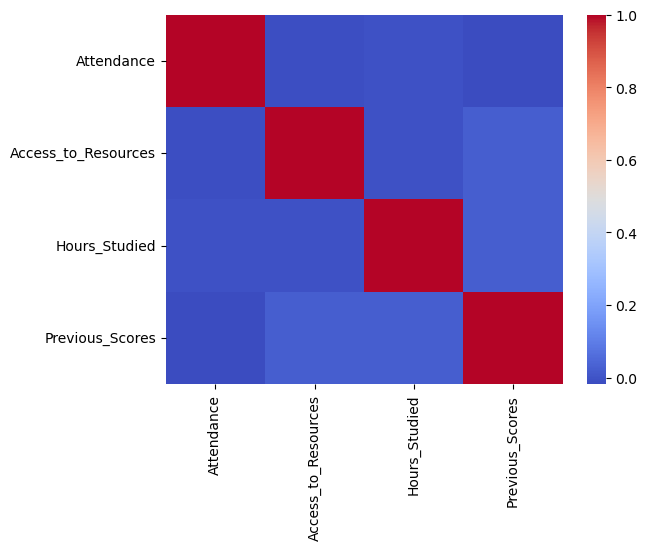

In [61]:
sns.heatmap(nsp[['Attendance', 'Access_to_Resources', 'Hours_Studied', 'Previous_Scores' ]].corr(), cmap = 'coolwarm')

Predictive Analytics: Exam Score Predictions Utilizing Performance Data

Since the outliers make up  <1% of the dataset, I'm going to filter them out while training my models.


Linear Regression:

In [62]:
low_score_nsp = nsp[nsp['Exam_Score'] < 80]

lsX = low_score_nsp.drop(['Exam_Score'], axis = 1).copy()
lsY = low_score_nsp[['Exam_Score']].copy()


lsX_train, lsX_test, lsY_train, lsY_test = train_test_split(lsX, lsY, train_size= 0.8, random_state= 42, shuffle = True)


lr = LinearRegression()  
lr.fit(lsX_train, lsY_train)
rounded_pred = np.round(lr.predict(lsX_test))

print(f'linear regression has an rmse of {root_mean_squared_error(lsY_test, rounded_pred)}')
print(f'linear regression has an r2 of {r2_score(lsY_test, rounded_pred)}')
print(f'the accuracy of the linear regression is {accuracy_score(lsY_test, rounded_pred)}')




linear regression has an rmse of 0.5485871556084577
linear regression has an r2 of 0.973189769151076
the accuracy of the linear regression is 0.9004739336492891


Decision Tree Regression:

In [63]:
dtr = DecisionTreeRegressor()


dtr.fit(lsX_train, lsY_train)

rounded_tree = np.round(dtr.predict(lsX_test))


print(f'decision tree regression has an rmse of {root_mean_squared_error(lsY_test, rounded_tree)}')
print(f'decision tree regression has an r2 of {r2_score(lsY_test, rounded_tree)}')
print(f'the accuracy of the decision tree regressor is {accuracy_score(lsY_test, rounded_tree)}')



decision tree regression has an rmse of 1.8412510342829478
decision tree regression has an r2 of 0.6979802866047728
the accuracy of the decision tree regressor is 0.2401263823064771


Random Forest Regression:

In [64]:
rfr = RandomForestRegressor()

rfr.fit(lsX_train, lsY_train)

rfr_preds = np.round(rfr.predict(lsX_test))

print(f'random forest regression has an rmse of {root_mean_squared_error(lsY_test, rfr_preds)}')
print(f'random forest regression has an r2 of {r2_score(lsY_test, rfr_preds)}')
print(f'the accuracy of the random forest is {accuracy_score(lsY_test, rfr_preds)}')




/opt/miniconda3/envs/cs111-env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


random forest regression has an rmse of 1.2003159141821218
random forest regression has an r2 of 0.8716486586130255
the accuracy of the random forest is 0.3688783570300158


The linear regression performs quite well when predicting the data. The R2 scores of the trees are not bad, but they have a relatively high error rate compared to linear regression.

Grid Search Cross Validation: Decision Tree

In [65]:
parameters = {'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
          'max_features': ["sqrt", "log2", None] ,
          'splitter': ['best', 'random']}

gs_tree = GridSearchCV(DecisionTreeRegressor(), parameters )

gs_tree.fit(lsX_train, lsY_train)


gst_preds = np.round(gs_tree.predict(lsX_test))


dtr_cv = gs_tree.best_estimator_


dtr_cv.fit(lsX_train, lsY_train)
dtr_cv_preds = np.round(dtr_cv.predict(lsX_test))



print(f'decision tree regression + grid search has an rmse of {root_mean_squared_error(lsY_test, dtr_cv_preds)}')
print(f'decision tree regression + grid search has an r2 of {r2_score(lsY_test, dtr_cv_preds)}')
print(f'the accuracy of the decision tree regressor + grid search is {accuracy_score(lsY_test, dtr_cv_preds)}')

decision tree regression + grid search has an rmse of 1.8279037796033335
decision tree regression + grid search has an r2 of 0.7023431063229704
the accuracy of the decision tree regressor + grid search is 0.2330173775671406


Grid Search Cross Validation: Random Forest

(The code is below; I commented it out because it took about a decade to run...)

In [66]:

# gs_rf = GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
#              param_grid={'criterion': ['squared_error', 'absolute_error','friedman_mse'],
#                          'max_features': ['sqrt', 'log2', None],
#                          'n_estimators': [100, 150],
#                          'warm_start': [True, False]})


#gs_rf.fit(lsX_train, lsY_train)

#print(gs_rf.best_estimator_)

#RandomForestRegressor(max_features=None, n_estimators=150, warm_start=True)

cv_rf = RandomForestRegressor(max_features=None, n_estimators=150, warm_start=True)

cv_rf.fit(lsX_train, np.ravel(lsY_train))

rf_cv_preds = np.round(cv_rf.predict(lsX_test))


print(f'random forest + grid search has an rmse of {root_mean_squared_error(lsY_test, rf_cv_preds)}')
print(f'random forest + grid search has an r2 of {r2_score(lsY_test, rf_cv_preds)}')
print(f'the accuracy of the random forest + grid search is {accuracy_score(lsY_test, rf_cv_preds)}')




random forest + grid search has an rmse of 1.1870815966982173
random forest + grid search has an r2 of 0.8744633810118627
the accuracy of the random forest + grid search is 0.36729857819905215


Grid Search was kind of a flop, I fear. It may just be the case the this data isn't well-suited to tree regression. Even if this is the case, let me know how I can improve my implementation of tree methods (and ML in general)!